<a href="https://colab.research.google.com/github/AI4Finance-LLC/Elegant-FinRL/blob/main/StockTrading_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stock Trading Demo in Elegant-FinRL**






# **Part 1: Problem Formulation**
Formally, we model stock trading as a Markov Decision Process (MDP), and formulate the trading objective as maximization of expected return:



*   **State s = [b, p, h]**: a vector that includes the remaining balance b, stock prices p, and stock shares h. p and h are vectors with D dimension, where D denotes the number of stocks. 
*   **Action a**: a vector of actions over D stocks. The allowed actions on each stock include selling, buying, or holding, which result in decreasing, increasing, or no change of the stock shares in h, respectively.
*   **Reward r(s, a, s’)**: The asset value change of taking action a at state s and arriving at new state s’.
*   **Policy π(s)**: The trading strategy at state s, which is a probability distribution of actions at state s.
*   **Q-function Q(s, a)**: the expected return (reward) of taking action a at state s following policy π.
*   **State-transition**: After taking the actions a, the number of shares h is modified, as shown in Fig 3, and the new portfolio is the summation of the balance and the total value of the stocks.

# **Part 2: Stock Trading Environment Design**

**State Space and Action Space**


*   **State Space**: We use a 181-dimensional vector consists of seven parts of information to represent the state space of multiple stocks trading environment: [b, p, h, M, R, C, X], where b is the balance, p is the stock prices, h is the number of shares, M is the Moving Average Convergence Divergence (MACD), R is the Relative Strength Index (RSI), C is the Commodity Channel Index (CCI), and X is the Average Directional Index (ADX).
*   **Action Space**: As a recap, we have three types of actions: selling, buying, and holding for a single stock. We use the negative value for selling, positive value for buying, and zero for holding. In this case, the action space is defined as {-k, …, -1, 0, 1, …, k}, where k is the maximum share to buy or sell in each transaction.


**Easy-to-customize Features**


*   **initial_capital**: the initial capital that the user wants to invest.
*   **tickers**: the stocks that the user wants to trade with.
*   **initial_stocks**: the initial amount of each stock and the default could be zero.
*   **buy_cost_pct, sell_cost_pct**: the transaction fee of each buying or selling transaction.
*   **max_stock**: the user is able to define the maximum number of stocks that are allowed to trade per transaction. Users can also set the maximum percentage of capitals to invest in each stock.
*   **tech_indicator_list**: the list of financial indicators that are taken into account, which is used to define a state.
*   **start_date, start_eval_date, end_eval_date**: the training and backtesting time intervals. Thee time dates (or timestamps) are used, once the training period is specified, the rest is backtesting.


# **Part 3: Install Elegant-FinRL and related packages**

In [ ]:
!pip install git+https://github.com/AI4Finance-LLC/Elegant-FinRL.git
!pip install git+https://github.com/quantopian/pyfolio

  Cloning https://github.com/AI4Finance-LLC/Elegant-FinRL.git to /tmp/pip-req-build-kuop7_lw
  Running command git clone -q https://github.com/AI4Finance-LLC/Elegant-FinRL.git /tmp/pip-req-build-kuop7_lw
     |████████████████████████████████| 63 kB 1.0 MB/s 
     |████████████████████████████████| 6.4 MB 30.6 MB/s 
  Created wheel for elegant-finrl: filename=elegant_finrl-0.3.1-py3-none-any.whl size=40693 sha256=b855039671756a5ecddf589238c82b18114bce943f2488df683ab001a64fddc2
  Stored in directory: /tmp/pip-ephem-wheel-cache-srbe6afa/wheels/21/88/62/c4783593d29e9a98ee3e5d778baa14290f2d4f4bf5b69198da
Successfully built elegant-finrl
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently 

# **Part 4: Import Packages**


*   **Elegant-FinRL**
*   **yfinance**: yfinance aims to solve this problem by offering a reliable, threaded, and Pythonic way to download historical market data from Yahoo! finance.
*   **StockDataFrame**: stockstats inherits and extends pandas.DataFrame to support Stock Statistics and Stock Indicators.



In [ ]:
!rm -r -f /content/elegant_finrl  # remove if the directory exists

In [ ]:
#from elegant_finrl.run import *
from agent import AgentPPO, AgentDDPG
from env import StockTradingEnv
import net
import config
import run
import numpy as np
import yfinance as yf
from stockstats import StockDataFrame as Sdf
import torch

# **Part 5: Specify Agent and Environment**

*   **args.agent**: firstly chooses one DRL algorithm to use from agent.py. In this application, we prefer to choose DDPG and PPO agent.
*   **args.env**: creates the environment, and the user can either customize own environment or preprocess environments from OpenAI Gym and PyBullet Gym from env.py. In this application, we create the self-designed stock trading environment.


> Before finishing initialization of **args**, please see Arguments() in run.py for more details about adjustable hyper-parameters.




In [ ]:
# Agent
args = run.Arguments(if_on_policy=True)
args.agent = AgentPPO() # AgentSAC(), AgentTD3(), AgentDDPG()
args.agent.if_use_gae = True
args.agent.lambda_entropy = 0.04

# Environment
tickers = ['AAPL', 'MSFT', 'JPM', 'V', 'RTX', 'PG', 'GS', 'NKE', 'DIS', 'AXP', 
           'HD', 'INTC', 'WMT', 'IBM', 'MRK', 'UNH', 'KO', 'CAT', 'TRV', 'JNJ',
           'CVX', 'MCD', 'VZ', 'CSCO', 'XOM', 'BA', 'MMM', 'PFE', 'WBA', 'DD']  

tech_indicator_list = [
  'macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30',
  'close_30_sma', 'close_60_sma']  # finrl.config.TECHNICAL_INDICATORS_LIST

gamma = 0.99
max_stock = 1e2
initial_capital = 1e6
initial_stocks = np.zeros(len(tickers), dtype=np.float32)
buy_cost_pct = 1e-3
sell_cost_pct = 1e-3
start_date = '2009-01-01'
start_eval_date = '2019-01-01'
end_eval_date = '2021-01-01'

args.env = StockTradingEnv('./', gamma, max_stock, initial_capital, buy_cost_pct, 
                           sell_cost_pct, start_date, start_eval_date, 
                           end_eval_date, tickers, tech_indicator_list, 
                           initial_stocks, reward_scaling=1e-4, if_eval=False)
args.env_eval = StockTradingEnv('./', gamma, max_stock, initial_capital, buy_cost_pct, 
                           sell_cost_pct, start_date, start_eval_date, 
                           end_eval_date, tickers, tech_indicator_list, 
                           initial_stocks, reward_scaling=1e-4, if_eval=True)

args.env.target_reward = 2
args.env_eval.target_reward = 2

# Hyperparameters
args.gamma = gamma
args.break_step = int(2e5)
args.net_dim = 2 ** 9
args.max_step = args.env.max_step
args.max_memo = args.max_step * 4
args.batch_size = 2 ** 10
args.repeat_times = 2 ** 3
args.eval_gap = 2 ** 4
args.eval_times1 = 2 ** 3
args.eval_times2 = 2 ** 5
args.if_allow_break = False
args.rollout_num = 2 # the number of rollout workers (larger is not always faster)

| FeatureEngineer: start processing data (2 minutes)
| YahooDownloader: start downloading data (1 minute)
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 complet

/content/env.py:357: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data_df = data_df.drop("adjcp", 1)


Shape of DataFrame:  (156457, 8)
29 {'RTX', 'HD', 'WMT', 'INTC', 'MSFT', 'DIS', 'XOM', 'CVX', 'MMM', 'PFE', 'CAT', 'IBM', 'DD', 'PG', 'VZ', 'WBA', 'AXP', 'BA', 'GS', 'MRK', 'NKE', 'JNJ', 'UNH', 'MCD', 'KO', 'CSCO', 'JPM', 'AAPL', 'TRV'}
| YahooDownloader: finish downloading data
Successfully added technical indicators
Successfully added turbulence index
| FeatureEngineer: finish processing data
| price_ary.shape: (2516, 30), tech_ary.shape: (2516, 240)
| price_ary.shape: (505, 30), tech_ary.shape: (505, 240)
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[**

# **Part 6: Train and Evaluate the Agent**

> The training and evaluating processes are all finished inside function **train_and_evaluate_mp()**, and the only parameter for it is **args**. It includes the fundamental objects in DRL:

*   agent,
*   environment.

> And it also includes the parameters for training-control:

*   batch_size,
*   target_step,
*   reward_scale,
*   gamma, etc.

> The parameters for evaluation-control:

*   break_step,
*   random_seed, etc.






In [ ]:
run.train_and_evaluate_mp(args) # the training process will terminate once it reaches the target reward.

| multiprocessing, act_workers: 2
| multiprocessing, None:
| GPU id: 0, cwd: ./AgentPPO/StockTradingEnv-v2_0
| Remove history
ID      Step      MaxR |    avgR      stdR       objA      objC


/content/agent.py:699: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  states = torch.as_tensor((state,), dtype=torch.float32, device=self.device).detach()
/content/agent.py:699: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  states = torch.as_tensor((state,), dtype=torch.float32, device=self.device).detach()
/content/run.py:448: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/ten

0   0.00e+00      1.19 |
0   1.01e+04      1.22 |
0   1.51e+04      1.23 |
0   2.52e+04      1.24 |
0   3.02e+04      1.24 |    1.24      0.01      -0.50      4.29
0   5.53e+04      1.24 |    1.11      0.00      -0.50      3.39
0   8.55e+04      1.24 |    1.15      0.00      -0.50      3.88
0   8.55e+04      1.28 |
0   9.56e+04      1.29 |
0   1.01e+05      1.35 |
0   1.11e+05      1.35 |    1.24      0.00      -0.50      4.30
0   1.31e+05      1.35 |    1.26      0.00      -0.50      3.45
0   1.56e+05      1.35 |    1.25      0.01      -0.50      4.29
0   1.96e+05      1.35 |    1.31      0.00      -0.50      3.39
| print_state_norm(): state_dim: (7545, 301) is too large to print its norm. 
| SavedDir: ./AgentPPO/StockTradingEnv-v2_0
| UsedTime: 1976


Understanding the above results::
*   **Step**: the total training steps.
*  **MaxR**: the maximum reward.
*   **avgR**: the average of the rewards.
*   **stdR**: the standard deviation of the rewards.
*   **objA**: the objective function value of Actor Network (Policy Network).
*   **objC**: the objective function value (Q-value)  of Critic Network (Value Network).

# **Part 7: Backtest and Draw the Graph**

In [ ]:
args = run.Arguments(if_on_policy=True)
args.agent = AgentPPO()
args.env = StockTradingEnv(cwd='./', if_eval=True)
args.if_remove = False
args.cwd = './AgentPPO/StockTradingEnv-v1_0'
args.init_before_training()

prediction = args.env.trade_prediction(args, torch)

| load data: .//StockTradingEnv_trading_data.df
| YahooDownloader: finish processing date list
| GPU id: 0, cwd: ./AgentPPO/StockTradingEnv-v1_0
FileNotFound when load_model: ./AgentPPO/StockTradingEnv-v1_0


[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (505, 8)


/content/env.py:357: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data_df = data_df.drop("adjcp", 1)


Start date,2019-01-02
End date,2020-12-31
Total months,24
,Backtest
Annual return,8.094%
Cumulative returns,16.879%
Annual volatility,14.792%
Sharpe ratio,0.60
Calmar ratio,0.44
Stability,0.22
Max drawdown,-18.559%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,18.56,2020-02-19,2020-03-23,2020-08-24,134
1,7.68,2020-09-02,2020-10-28,2020-11-09,49
2,2.52,2020-11-16,2020-11-20,2020-11-24,7
3,1.88,2020-12-04,2020-12-14,2020-12-28,17
4,1.68,2019-09-06,2019-10-02,2019-12-13,71


Stress Events,mean,min,max
New Normal,0.04%,-6.58%,5.83%


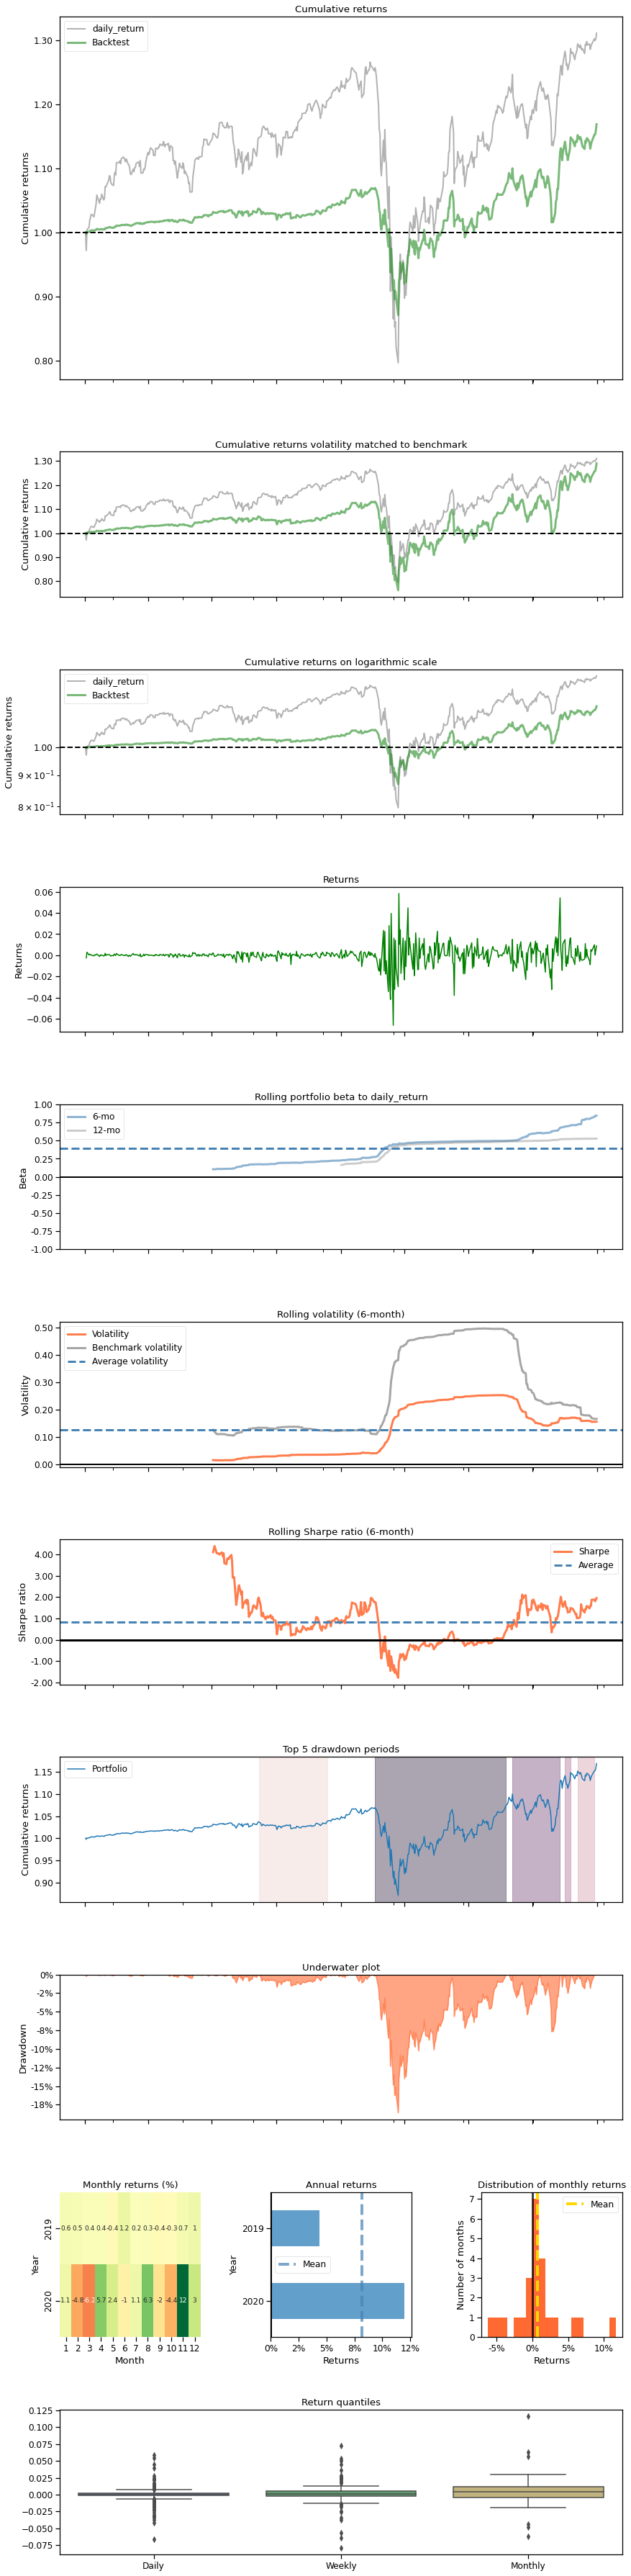

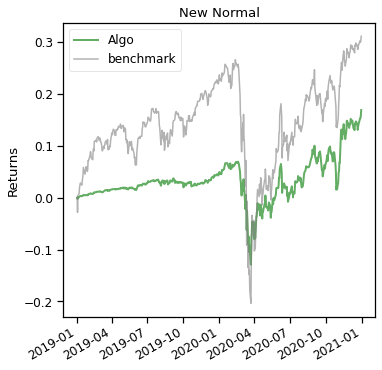

In [ ]:
args.env.backtest_plot(prediction, baseline_ticker = '^DJI', baseline_start = '2019-01-01', baseline_end = '2021-01-01')